In [10]:
import tensorflow
import os
import shutil
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import joblib
import tensorflow_addons as tfa
import tempfile
import seaborn as sns

from os import listdir
from os.path import isfile, join
import math
from matplotlib.gridspec import GridSpec
import random



### Defining Model Structure

Here we define our model structure using data augmentation to augment are training dataset and then call this function to create a model.

In [11]:
image_height, image_width = 500, 500
batch_size = 256
epochs = 3

def create_model(image_height, image_width,  cost_function):

    # Defining data augmentation layer
    data_augmentation = keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            ])
    #Defining model
    model = keras.Sequential([
            data_augmentation,
            keras.layers.Rescaling(1./255),
            keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
    #Compiling
    model.compile(loss='binary_crossentropy',
                        optimizer='adam', 
                        metrics=[cost_function])
    return model

def plot_result(history):
    acc = history.history['F1Score']
    val_acc = history.history['val_F1Score']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def plot_cm(labels, predictions, threshold):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def make_predictions(model, val_ds, threshold):

    "Takes model + validation dataframe as input, returns predictions and labels"

    labels =  np.array([])
    predictions =  np.array([])
    # Iterating through batches and making predictions
    for x, y in val_ds:
        labels = np.concatenate([labels, y.numpy()])
        predictions = np.concatenate([predictions, 
                                        [round(i[0],0) for i in model.predict(x).tolist()]])

    # Converting to 1/0 depending on value relative to threshold
    predictions = [1 if i >= threshold else 0 for i in predictions]
    # Converting to int type
    predictions = np.array(predictions).astype(int)
    labels = np.array(labels).astype(int)

    return predictions, labels

def visualize_f1(histories):
    
    '''Takes dataframe containing keras training results, displays grid
    of val/train F1 Score over epoch'''
    
    graph_count = len(histories)
    rows = 1
    columns = int(math.ceil(graph_count/rows))
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(nrows=rows, ncols=columns)
    keys = list(histories.keys())
    for model in range(len(histories.keys())):
        ax = fig.add_subplot(gs[int(math.floor(model/columns)), model%columns])
        ax.plot(histories[model]['Results'].index, histories[model]['Results']['f1_score'], label="Train f1")
        ax.plot(histories[model]['Results'].index, histories[model]['Results']['val_f1_score'], label="Val f1")
        plt.legend(loc="upper left")
        plt.grid(True)
        
        #Returning accuracy and formatting
        accuracy = round(histories[keys[model]]['Results']['val_f1_score'].max(),4)
        plt.title("Model {graph} f1 score {accuracy}".format(graph = model,
                                                 accuracy = accuracy))
        
    plt.tight_layout()
    plt.show()  
   
   
   

In [12]:
# Creating model for 500 x 500 image with a 0.5 classification threshold
my_model = create_model(image_height, image_width, 0.5)

### Loading Data
Reaing in the images from our directory

In [13]:
# Path to read data from
data_dir = './Data-Clean/'

# Defining train an validation splits using 80/20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

print(type(train_ds))

Found 20637 files belonging to 2 classes.
Using 16510 files for training.
Found 20637 files belonging to 2 classes.
Using 4127 files for validation.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


### Visualizing Data

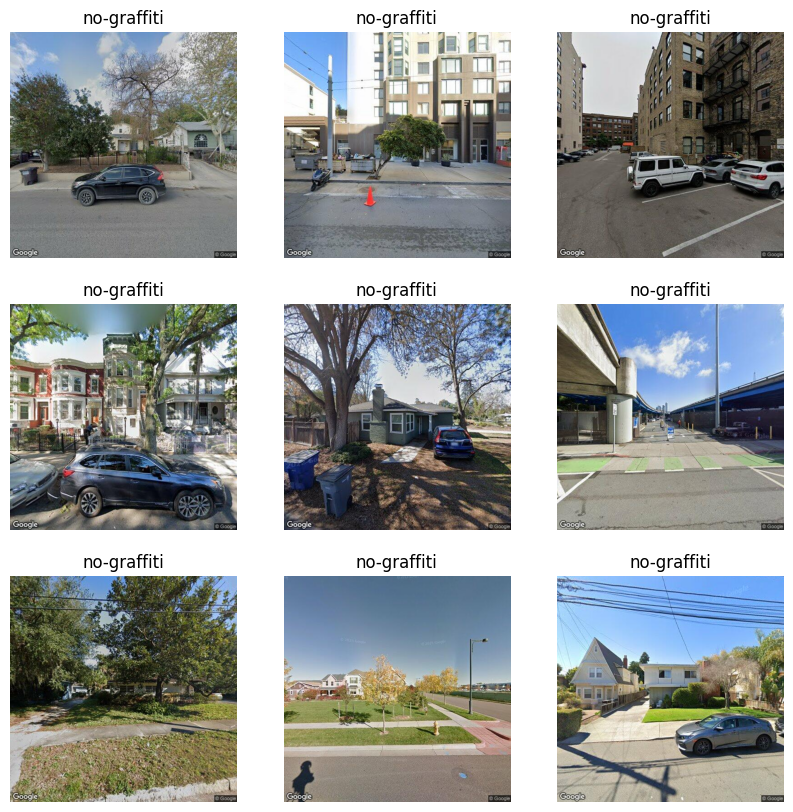

In [14]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Naive Approach - Modeling With Accuracy

Training 3 different models with differing cuttoffs

In [ ]:
path = os.getcwd() + '/models'
file_list = [f for f in listdir(path) if isfile(join(path, f))]

# Defining thresholds
low_threshold, medium_threshold, high_threshold  = 0.25, 0.5, 0.75

# Initializing and compiling models
naive_low_model = create_model(image_height, image_width, "accuracy")
naive_medium_model = create_model(image_height, image_width, "accuracy")
naive_high_model = create_model(image_height, image_width, "accuracy")

# only training if the model doesnt already exist then 
if "naive_normal_model.pkl" not in file_list:
  history = naive_medium_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(naive_medium_model, './models/naive_medium_model.pkl')
  pd.DataFrame(history.history).to_csv('./history/naive_medium_history.csv')
if "naive_low_threshold_model.pkl" not in file_list:
  low_threshold_history = naive_low_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  pd.DataFrame(low_threshold_history.history).to_csv('./history/naive_low_history.csv')
  joblib.dump(naive_low_model, './models/naive_low_model.pkl')
if "naive_high_model.pkl" not in file_list:
  high_threshold_history = naive_high_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(naive_high_model, './models/naive_high_model.pkl')
  pd.DataFrame(high_threshold_history.history).to_csv('./history/naive_high_history.csv')

### Training Models Using F1 Score

Now that we have our training data and model defined we can now train it

In [15]:
# Initializing and compiling models
normal_threshold_model = create_model(image_height, image_width, 
                                      tfa.metrics.F1Score(num_classes = 2, threshold = low_threshold, average="micro"))
low_threshold_model = create_model(image_height, image_width, 
                                   tfa.metrics.F1Score(num_classes = 2, threshold = medium_threshold, average="micro"))
high_threshold_model = create_model(image_height, image_width, 
                                    tfa.metrics.F1Score(num_classes = 2, threshold = high_threshold, average="micro"))

# only training if the model doesnt already exist then 
if "normal_model.pkl" not in file_list:
  history = my_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(my_model, './models/my_model.pkl')
  # Writing history to csv
  pd.DataFrame(history.history).to_csv('./history/medium_threshold_history.csv')
if "low_threshold_model.pkl" not in file_list:
  low_threshold_history = low_threshold_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  pd.DataFrame(low_threshold_history.history).to_csv('./history/low_threshold_history.csv')
  joblib.dump(low_threshold_model, './models/low_threshold_model.pkl')
if "high_threshold_model.pkl" not in file_list:
  high_threshold_history = high_threshold_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(high_threshold_model, './models/high_threshold_model.pkl')
  pd.DataFrame(high_threshold_history.history).to_csv('./history/high_threshold_history.csv')

### Evaluating Performence

In [16]:
# First making predictions on test and train datasets
train_predictions_baseline = my_model.predict(train_ds, batch_size=batch_size)
test_predictions_baseline = my_model.predict(val_ds, batch_size=batch_size)
predictions, labels = make_predictions(my_model, val_ds, 0.5)

1/1 [==============================] - 0s 374ms/step


Legitimate Transactions Detected (True Negatives):  0
Legitimate Transactions Incorrectly Detected (False Positives):  141
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  3984
Total Fraudulent Transactions:  3986


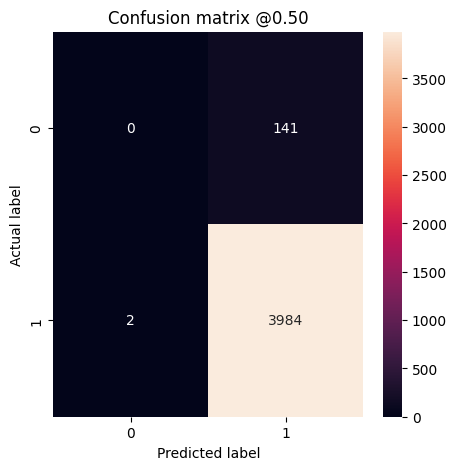

In [17]:
# Generating confusion matrix on test set
plot_cm(labels, predictions, 0.5)

1/1 [==============================] - 0s 409ms/step
Legitimate Transactions Detected (True Negatives):  137
Legitimate Transactions Incorrectly Detected (False Positives):  4
Fraudulent Transactions Missed (False Negatives):  3938
Fraudulent Transactions Detected (True Positives):  48
Total Fraudulent Transactions:  3986


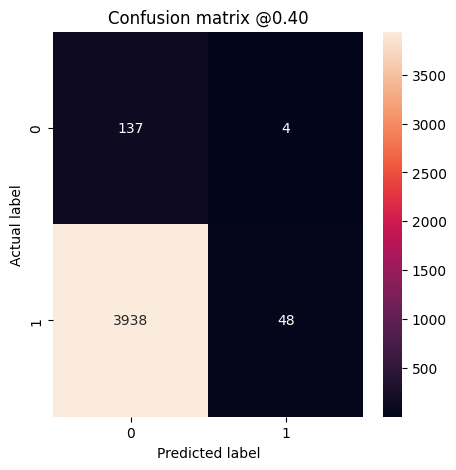

In [18]:
low_threshold_predictions, low_threshold_labels = make_predictions(low_threshold_model, val_ds, 0.4)
# Generating confusion matrix on test set
plot_cm(low_threshold_labels, low_threshold_predictions, 0.4)

1/1 [==============================] - 0s 436ms/step
Legitimate Transactions Detected (True Negatives):  139
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  3986
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  3986


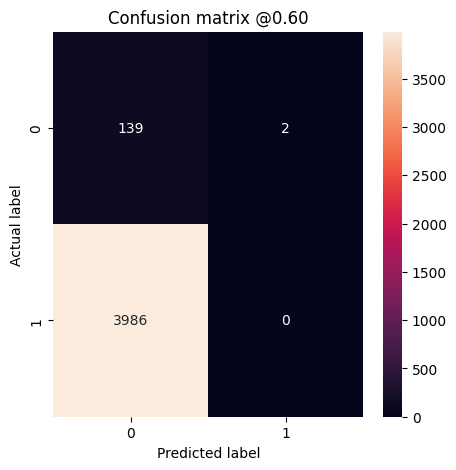

In [19]:
high_threshold_predictions, high_threshold_labels = make_predictions(high_threshold_model, val_ds, 0.6)
# Generating confusion matrix on test set
plot_cm(high_threshold_labels, high_threshold_predictions, 0.6)

### Creating Single Function to Display 3 Confusion Matrices

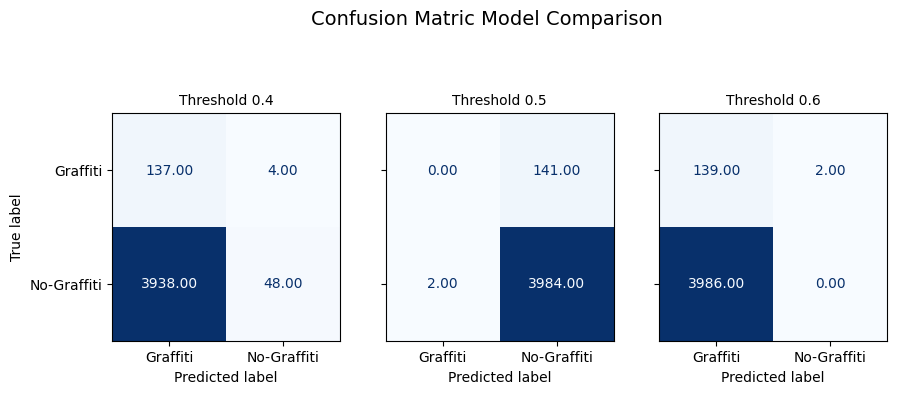

In [36]:
cmap = "Blues"
colorbar = False
display_labels = ["Graffiti", "No-Graffiti"]
values_format = ".2f"
f, axes = plt.subplots(1, 3, figsize=(10, 5))

low_threshold = 0.4
medium_threshold = 0.5
high_threshold = 0.6

# Creating confusion matrices
cm1 = confusion_matrix(low_threshold_labels, low_threshold_predictions > low_threshold)
cm2 = confusion_matrix(labels, predictions > medium_threshold)
cm3 = confusion_matrix(high_threshold_labels, high_threshold_predictions > high_threshold)

# Assembling into subplot
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2], colorbar=colorbar, values_format=values_format)

# Removing extra y axis lables
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[1].yaxis.set_ticklabels([ '', ''])
axes[2].yaxis.set_ticklabels([ '', ''])

# Adding Titles
title_size = 10
axes[0].set_title("Threshold 0.4", size=title_size)
axes[1].set_title("Threshold 0.5", size=title_size)
axes[2].set_title("Threshold 0.6", size=title_size)

f.suptitle("Confusion Matric Model Comparison", size=14, y=0.93)
plt.show()

### Comparing Training Across Models

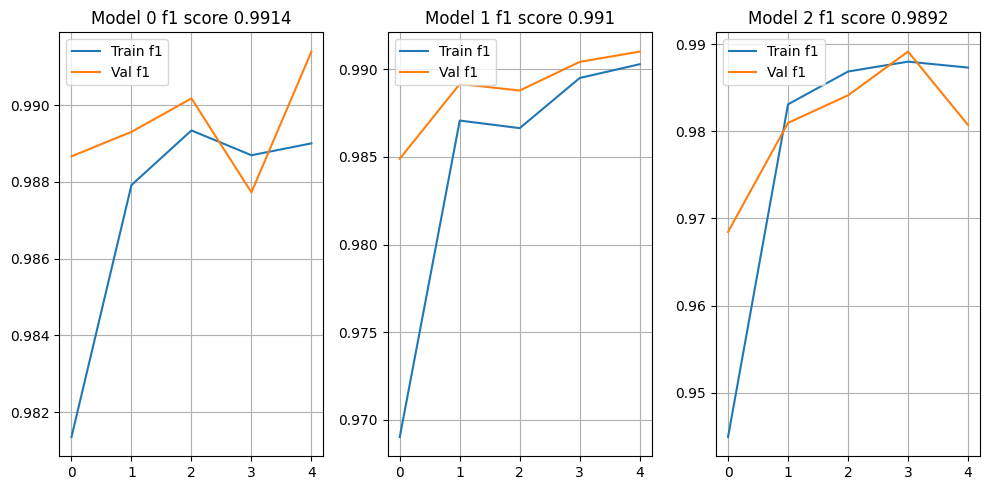

In [ ]:
models = [low_threshold_model, my_model, high_threshold_model]
history = [pd.read_csv('./history/low_threshold_history.csv'), 
           pd.read_csv('./history/medium_threshold_history.csv'), 
           pd.read_csv('./history/high_threshold_history.csv')]
histories = {}

# Aggregating model performance for comparison
for i in range(len(models)):
    histories[i] = {'Results' :pd.DataFrame(history[i]),
                            'Model' : history,
                            'End Score': history[i]['val_f1_score']}

#Viualizing training histories
visualize_f1(histories)

## Engineering New Dataset by Oversampling


In [ ]:
# Defining train an validation splits using 80/20 split
second_train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=256,
  labels = "inferred")

second_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=1)
print(type(second_train_ds))

Found 20637 files belonging to 2 classes.
Using 16510 files for training.
Found 20637 files belonging to 2 classes.
Using 4127 files for validation.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
# Filtering for graffiti, y == 1 and no graffiti, y != 1
pos_df = second_train_ds.unbatch().filter(lambda img, label: label == 1)
neg_df = second_train_ds.unbatch().filter(lambda img, label: label != 1)

print(type(pos_df))
print(second_train_ds)

<class 'tensorflow.python.data.ops.filter_op._FilterDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


tf.Tensor(
[[[199. 165.  55.]
  [222. 177.  77.]
  [226. 183.  68.]
  ...
  [238. 234. 246.]
  [177. 168. 187.]
  [136. 127. 146.]]

 [[187. 146.  23.]
  [188. 136.  24.]
  [204. 151.  42.]
  ...
  [182. 177. 194.]
  [133. 125. 144.]
  [106.  97. 116.]]

 [[236. 185.  62.]
  [228. 169.  47.]
  [208. 149.  32.]
  ...
  [111. 105. 123.]
  [157. 148. 167.]
  [ 77.  68.  87.]]

 ...

 [[ 29.  22.  30.]
  [ 39.  32.  40.]
  [ 42.  35.  43.]
  ...
  [213. 199. 190.]
  [207. 193. 184.]
  [210. 196. 187.]]

 [[ 29.  22.  30.]
  [ 39.  32.  40.]
  [ 42.  35.  43.]
  ...
  [201. 187. 178.]
  [205. 191. 182.]
  [215. 201. 192.]]

 [[ 29.  22.  30.]
  [ 39.  32.  40.]
  [ 42.  35.  43.]
  ...
  [217. 203. 194.]
  [207. 193. 184.]
  [208. 194. 185.]]], shape=(500, 500, 3), dtype=float32)
1


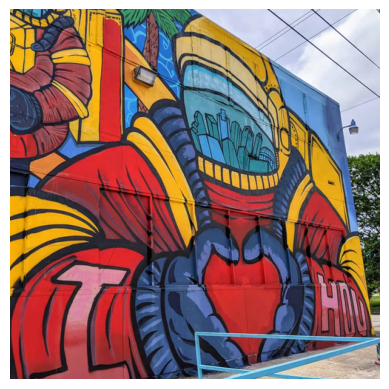

In [ ]:
count = 0
for example in neg_df:
    count += 1
    print(example[0])
    print(count)
    ax = plt.subplot(1, 1, 1)
    plt.imshow(example[0].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")
    break

In [ ]:
def random_sample(image_count, positive_df, negative_df):

    """Takes Positive + negative tensorflow Datasets and returns balanced
    dataset of length equal to 'image_count'"""
    
    random.seed(14)
    positive_images = [img[0].numpy().astype("uint8") for img in positive_df]
    negative_images = [img[0].numpy().astype("uint8") for img in negative_df]
    X = []
    y = []
    # Assembling new x and y
    for i in range(int(image_count/2)):
        rand_pos = random.randint(0,len(positive_images)-1)
        rand_neg = random.randint(0,len(negative_images)-1)

        X.append(positive_images[rand_pos])
        X.append(negative_images[rand_neg])
        y.append(1)
        y.append(0)

    return X, y


In [ ]:
# Creating oversampled dataset for training
resampled_train_ds, resampled_y = random_sample(1000, pos_df, neg_df)

In [ ]:
# Converting numpy array to batched tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((resampled_train_ds, resampled_y)).batch(batch_size, drop_remainder=True)

### Training model on subsampled Dataset

In [ ]:
smote05_model = create_model(image_height, image_width, 0.5)
smote04_model = create_model(image_height, image_width, 0.4)
smote06_model = create_model(image_height, image_width, 0.6)
neg = 141 # Manually set, will need to adjust
resampled_steps_per_epoch = np.ceil(2.0*neg/batch_size)

# only training if the model doesnt already exist then 
if "smote_05_model.pkl" not in file_list:
  history = smote05_model.fit(
    train_dataset,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(my_model, './models/smote_05_model.pkl')
  pd.DataFrame(history.history).to_csv('./history/smote05_threshold_history.csv')
if "smote_06_model.pkl" not in file_list:
  history = smote06_model.fit(
    train_dataset,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(my_model, './models/smote_06_model.pkl')
  pd.DataFrame(history.history).to_csv('./history/smote06_threshold_history.csv')
if "smote_04_model.pkl" not in file_list:
  history = smote04_model.fit(
    train_dataset,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(my_model, './models/smote_04_model.pkl')
  pd.DataFrame(history.history).to_csv('./history/smote04_threshold_history.csv')

Epoch 1/5
3/3 [==============================] - 78s 31s/step - loss: 16.4932 - f1_score: 0.4000 - val_loss: 28.2533 - val_f1_score: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 72s 30s/step - loss: 7.1728 - f1_score: 0.0000e+00 - val_loss: 0.1797 - val_f1_score: 0.9826
Epoch 3/5
3/3 [==============================] - 72s 31s/step - loss: 1.8450 - f1_score: 0.6690 - val_loss: 1.4842 - val_f1_score: 0.3119
Epoch 4/5
3/3 [==============================] - 73s 30s/step - loss: 0.7104 - f1_score: 0.2423 - val_loss: 0.7880 - val_f1_score: 0.3601
Epoch 5/5
3/3 [==============================] - 73s 31s/step - loss: 0.5731 - f1_score: 0.5772 - val_loss: 0.7128 - val_f1_score: 0.6753
Epoch 1/5
3/3 [==============================] - 84s 34s/step - loss: 20.0327 - f1_score: 0.0000e+00 - val_loss: 0.3430 - val_f1_score: 0.9826
Epoch 2/5
3/3 [==============================] - 76s 32s/step - loss: 3.3713 - f1_score: 0.6667 - val_loss: 0.3359 - val_f1_score: 0.9820
Epoch 3/5
3/3 [====

1/1 [==============================] - 0s 380ms/step
Legitimate Transactions Detected (True Negatives):  129
Legitimate Transactions Incorrectly Detected (False Positives):  12
Fraudulent Transactions Missed (False Negatives):  1948
Fraudulent Transactions Detected (True Positives):  2038
Total Fraudulent Transactions:  3986


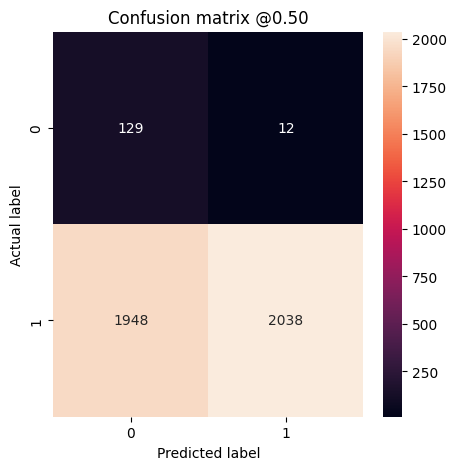

In [ ]:
smote05_predictions, smote05_labels = make_predictions(smote05_model, val_ds, 0.5)
# Generating confusion matrix on test set
plot_cm(smote05_labels, smote05_predictions, 0.5)

1/1 [==============================] - 0s 379ms/step
Legitimate Transactions Detected (True Negatives):  8
Legitimate Transactions Incorrectly Detected (False Positives):  133
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  3974
Total Fraudulent Transactions:  3986


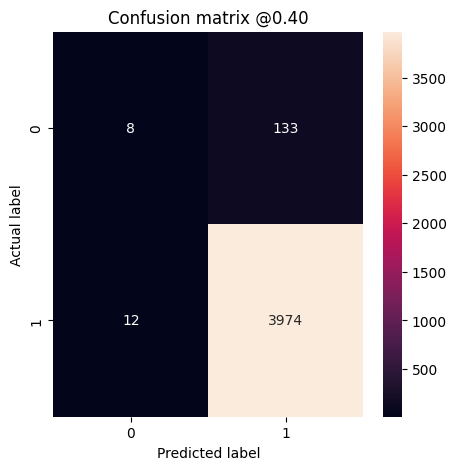

In [ ]:
smote04_predictions, smote04_labels = make_predictions(smote04_model, val_ds, 0.4)
# Generating confusion matrix on test set
plot_cm(smote04_labels, smote04_predictions, 0.4)

1/1 [==============================] - 0s 384ms/step
Legitimate Transactions Detected (True Negatives):  141
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  3986
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  3986


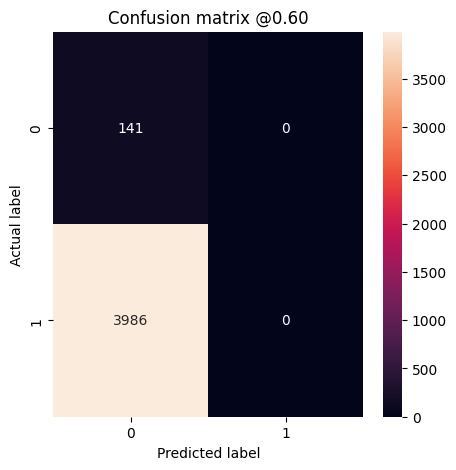

In [ ]:
smote06_predictions, smote06_labels = make_predictions(smote06_model, val_ds, 0.6)
# Generating confusion matrix on test set
plot_cm(smote06_labels, smote06_predictions, 0.6)

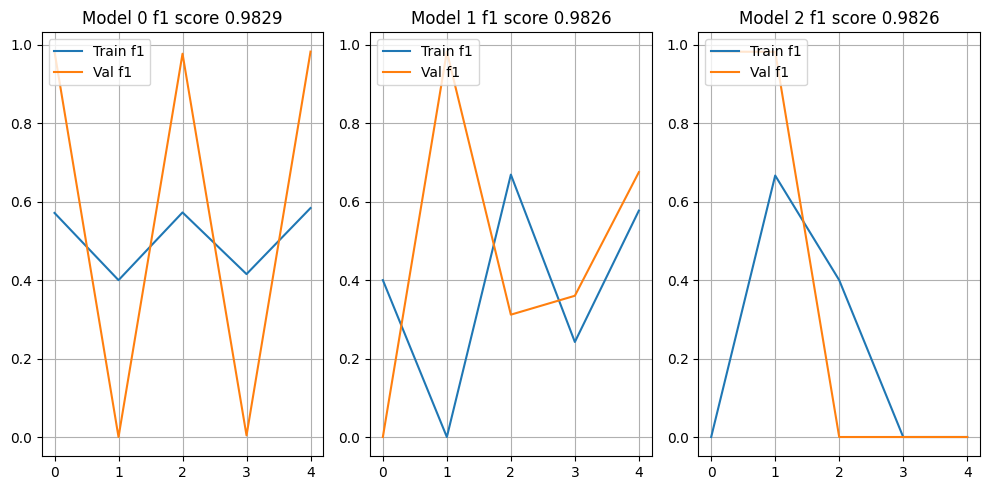

In [ ]:
models = [smote04_model, smote05_model, smote06_model]
history_smote = [pd.read_csv('./history/smote04_threshold_history.csv'), 
                pd.read_csv('./history/smote05_threshold_history.csv'), 
                pd.read_csv('./history/smote06_threshold_history.csv')]
accuracy = []
histories_smote = {}

# Aggregating model performance for comparison
for i in range(len(models)):
    histories_smote[i] = {'Results' :pd.DataFrame(history_smote[i]),
                            'Model' : history_smote,
                            'End Score': history_smote[i]['val_f1_score']}

#Viualizing training histories
visualize_f1(histories_smote)